# Bachelor Thesis

## Konfiguration

In [42]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [43]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = (10, 5)

In [58]:
df = pd.read_csv('meter_data.csv', parse_dates=['datum_zeit']).dropna(axis=1)
df = df.set_index('datum_zeit')
df.head()

,zaehler_id,obis_180,obis_170
datum_zeit,,,
2018-08-28 20:19:00,1ESY1312000449,17714.93,326.20
2018-08-28 20:20:00,1ESY1312000449,17714.94,263.54
2018-08-28 20:21:00,1ESY1312000449,17714.94,260.90
2018-08-28 20:22:00,1ESY1312000449,17714.95,259.50
2018-08-28 20:23:00,1ESY1312000449,17714.95,262.84


View the first and last date available in the dataset

In [45]:
df.index.min(), df.index.max()

(Timestamp('2018-08-28 20:19:00'), Timestamp('2019-10-20 19:57:00'))

Add additional columns to be used later

In [59]:
df = df.dropna(axis=1)
df['diff'] = df['obis_180'].diff()
df['time'] = df.index.time
df['date'] = df.index.date
df['weekday'] = df.index.day_name()
df.head()

,zaehler_id,obis_180,obis_170,diff,time,date,weekday
datum_zeit,,,,,,,
2018-08-28 20:19:00,1ESY1312000449,17714.93,326.20,NaN,20:19:00,2018-08-28,Tuesday
2018-08-28 20:20:00,1ESY1312000449,17714.94,263.54,0.01,20:20:00,2018-08-28,Tuesday
2018-08-28 20:21:00,1ESY1312000449,17714.94,260.90,0.00,20:21:00,2018-08-28,Tuesday
2018-08-28 20:22:00,1ESY1312000449,17714.95,259.50,0.01,20:22:00,2018-08-28,Tuesday
2018-08-28 20:23:00,1ESY1312000449,17714.95,262.84,0.00,20:23:00,2018-08-28,Tuesday


## Analyze dataset

In [47]:
df['diff'].describe()

count    581359.000000
mean          0.006382
std           0.121303
min           0.000000
25%           0.000000
50%           0.000000
75%           0.010000
max          91.960000
Name: diff, dtype: float64

In [48]:

df.groupby('weekday')['diff'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
Friday,83512.0,0.006135,0.009154,0.0,0.0,0.00,0.01,0.11
Monday,81461.0,0.005308,0.026112,0.0,0.0,0.00,0.01,7.13
Saturday,83520.0,0.007750,0.011065,0.0,0.0,0.01,0.01,0.13
Sunday,83278.0,0.006623,0.009586,0.0,0.0,0.00,0.01,0.12
Thursday,83519.0,0.006251,0.009150,0.0,0.0,0.00,0.01,0.13
Tuesday,82300.0,0.005279,0.007548,0.0,0.0,0.00,0.01,0.10
Wednesday,83769.0,0.007284,0.317828,0.0,0.0,0.00,0.01,91.96


Regarding the diff distribution, a big spike is apparent on Mondays and Wednesdays. Plotting the values shows the following: 

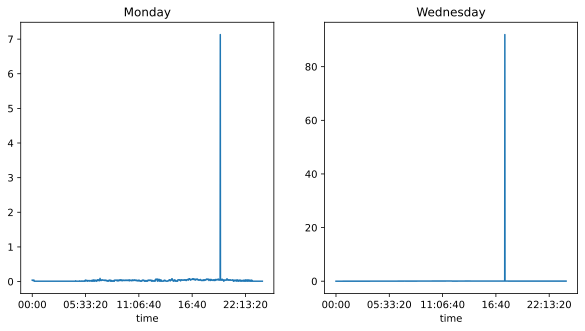

In [49]:
fig = plt.figure()
ax_mon = fig.add_subplot(121)
ax_wed = fig.add_subplot(122)
ax_mon.set_title("Monday")
ax_wed.set_title("Wednesday")
df.loc[df['weekday']=='Monday'].groupby('time')['diff'].max().plot(ax=ax_mon)
df.loc[df['weekday']=='Wednesday'].groupby('time')['diff'].max().plot(ax=ax_wed)

It seems that the maximum 'normal' value is not higher than 0.2. Therefore, all values > 0.2 shall be analyzed.

In [50]:
df.loc[df['diff'] > 0.2]

,zaehler_id,obis_180,obis_170,diff,time,date,weekday
datum_zeit,,,,,,,
2019-02-18 19:36:00,1ESY1312000449,19375.03,187.74,7.13,19:36:00,2019-02-18,Monday
2019-06-26 17:36:00,1ESY1312000449,20472.14,353.58,91.96,17:36:00,2019-06-26,Wednesday


To be able to exactly understand why these spikes are present, the meter values as well as the differences have to be plotted.

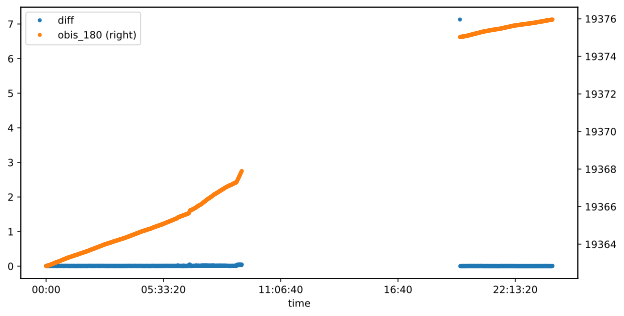

In [51]:
fig, ax = plt.subplots()
df['2019-02-18'].plot(x='time', y='diff', style='.', ax=ax)
df['2019-02-18'].plot(x='time', y='obis_180', style='.', ax=ax, secondary_y=True)

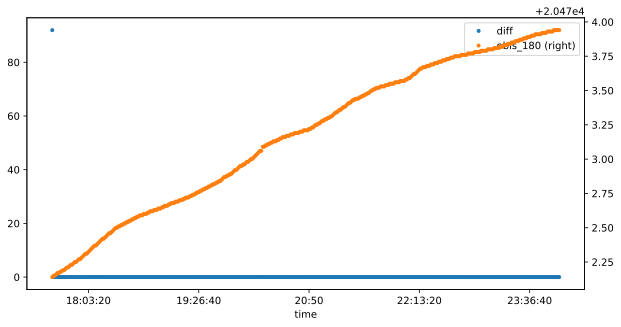

In [52]:
fig, ax = plt.subplots()
df['2019-06-26'].plot(x='time', y='diff', style='.', ax=ax)
df['2019-06-26'].plot(x='time', y='obis_180', style='.', ax=ax, secondary_y=True)

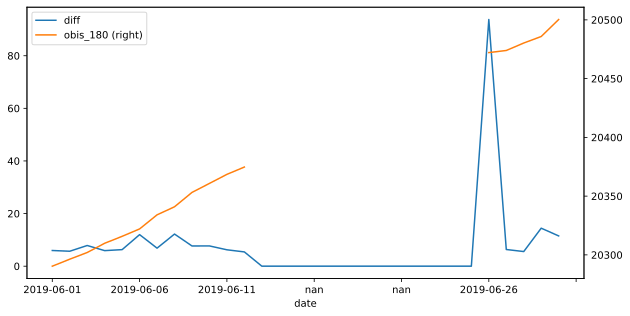

In [53]:
fig, ax = plt.subplots()
df['2019-06'].resample('D').agg({'obis_180': 'first', 'diff': 'sum', 'date': 'first'}).plot(x='date', y='diff', ax=ax)
df['2019-06'].resample('D').agg({'obis_180': 'first', 'diff': 'sum', 'date': 'first'}).plot(x='date', y='obis_180', ax=ax, secondary_y=True)

### Interpolation

In [86]:
a = df.loc[~df.index.duplicated(keep='first')]
b = df.merge(a, how='outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
b

,zaehler_id,obis_180,obis_170,diff,time,date,weekday,_merge
86800,1ESY1312000449,18200.85,156.90,0.01,02:00:00,2018-10-28,Sunday,left_only
86801,1ESY1312000449,18200.85,147.25,0.00,02:01:00,2018-10-28,Sunday,left_only
86802,1ESY1312000449,18200.85,146.79,0.00,02:02:00,2018-10-28,Sunday,left_only
86803,1ESY1312000449,18200.85,146.57,0.00,02:03:00,2018-10-28,Sunday,left_only
86804,1ESY1312000449,18200.86,146.44,0.01,02:04:00,2018-10-28,Sunday,left_only
86805,1ESY1312000449,18200.86,146.93,0.00,02:05:00,2018-10-28,Sunday,left_only
86806,1ESY1312000449,18200.86,181.99,0.00,02:06:00,2018-10-28,Sunday,left_only
86807,1ESY1312000449,18200.86,181.06,0.00,02:07:00,2018-10-28,Sunday,left_only
86808,1ESY1312000449,18200.87,117.48,0.01,02:08:00,2018-10-28,Sunday,left_only
86809,1ESY1312000449,18200.87,117.58,0.00,02:09:00,2018-10-28,Sunday,left_only


In [98]:
df['idx'] = [i for i in range(df.index.size)]
df['2018-10-28 02:33']

,zaehler_id,obis_180,obis_170,diff,time,date,weekday,idx
datum_zeit,,,,,,,,
2018-10-28 02:33:00,1ESY1312000449,18200.76,116.53,0.0,02:33:00,2018-10-28,Sunday,86773
2018-10-28 02:33:00,1ESY1312000449,18200.92,146.90,0.0,02:33:00,2018-10-28,Sunday,86833


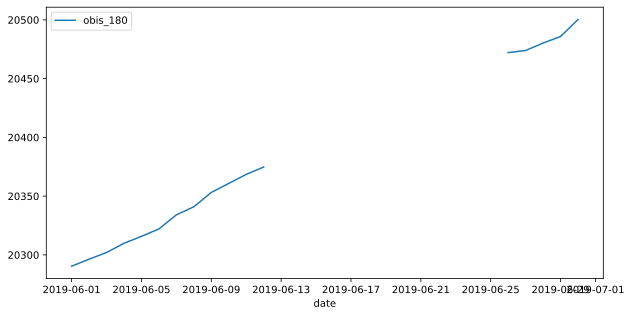

In [114]:
df = df.loc[~df.index.duplicated(keep='first')]
idx = pd.date_range(df.index.min(), df.index.max(), freq='T')
a = df.reindex(idx)
a['time'] = a.index.time
a['date'] = a.index.date
a['weekday'] = a.index.day_name()
a['2019-06'].resample('D').agg({'obis_180': 'first', 'diff': 'sum', 'date': 'first'}).plot(x='date', y='obis_180')

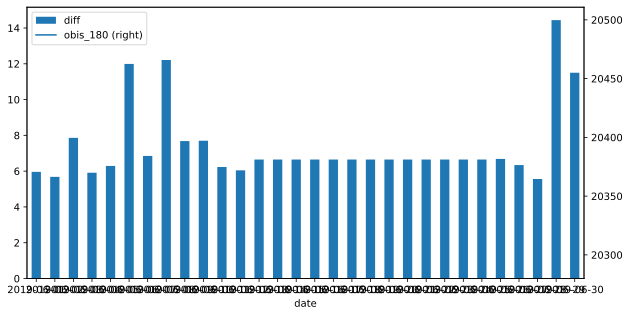

In [118]:
a = a.interpolate()
a['diff'] = a['obis_180'].diff()
fig, ax = plt.subplots()
t = a['2019-06'].resample('D').agg({'obis_180': 'first', 'diff': 'sum', 'date': 'first'})
t.plot(x='date', y='diff', ax=ax, kind='bar')
t.plot(x='date', y='obis_180', ax=ax, secondary_y=True)

## 3D mesh plot

In [56]:
df_grid = df.resample('60T').sum()
df_grid['time'] = df_grid.index.time
df_grid['date'] = df_grid.index.date
df_grid = df_grid.groupby(['time','date'])['diff'].unstack().fillna(0)
df_grid = df_grid.reset_index()
df_grid = df_grid.drop(columns='time')
df_grid.columns = [i for i in range(406)]
df_grid.head()

AttributeError: 'SeriesGroupBy' object has no attribute 'unstack'

In [57]:
x = df_grid.columns
y = df_grid.index
X,Y = np.meshgrid(x,y)
Z = df_grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.axes.set_zlim3d(bottom=0, top=0.09) 
ax.plot_surface(X, Y, Z)
#d = df.resample('60T').agg({'obis_180': 'first', 'diff': 'sum'})
#d['time'] = d.index.time
#d['date'] = d.index.date
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''